In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook

from scipy import signal

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d

from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

In [3]:
df = pd.read_csv('data/capture_mcu_input.csv', names=('raw_current', 'busvoltage', 'raw_shuntvoltage', 'power'))
print(df.head())

df_current = gaussian_filter1d(df['raw_current'] / 20, 3)
df_voltage = df['busvoltage'] / 1000

x = np.arange(len(df_current)) * 10

current_line = go.Scatter(x=x, y=df_current, name='I (mA)')
voltage_line = go.Scatter(x=x, y=df_voltage, name='Vbus (V)')

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(current_line, secondary_y=False)
fig.add_trace(voltage_line, secondary_y=True)

fig.update_layout(title_text='V/I measured coming into MCU')
fig.update_xaxes(title_text='T (ms)')

fig.show()

   raw_current  busvoltage  raw_shuntvoltage  power
0          522        6604               502    331
1          480        6696               500    329
2          484        6748               425    280
3          520        6604               505    333
4          478        6696               499    329


In [4]:
df_sweep = pd.read_csv('data/capture_psu_sweep.csv', names=('raw_current', 'busvoltage', 'raw_shuntvoltage', 'power'))

df_current = df_sweep['raw_current'] / 20
df_voltage = df_sweep['busvoltage'] / 1000

# df_current = (df_current - min(df_current)) / (max(df_current) - min(df_current))
# df_voltage = (df_voltage - min(df_voltage)) / (max(df_voltage) - min(df_voltage))

x = np.arange(len(df_current)) * 0.010

current_line = go.Scatter(x=x, y=df_current, name='I (mA)')
voltage_line = go.Scatter(x=x, y=df_voltage, name='Vbus (V)')

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(current_line, secondary_y=False)
fig.add_trace(voltage_line, secondary_y=True)

fig.update_layout(title_text='V/I measured coming into MCU using PSU sweep from 7-8V')
fig.update_xaxes(title_text='T (s)')

fig.show()

In [5]:
from pathlib import Path

data_path = Path('data/samples')
dfs = {}

for sample_file in data_path.glob('*'):
    filename = sample_file.stem.split('_')
    flowrate = float(filename[-2] + '.' + filename[-1])
    dfs[flowrate] = pd.read_csv(sample_file, names=('raw_current', 'busvoltage', 'raw_shuntvoltage', 'power'))

dfs = dict(sorted(dfs.items(), key=lambda d: d[0]))
print('flowrates:', dfs.keys())

flowrates: dict_keys([7.5, 7.8, 8.0, 8.3, 8.5, 8.7, 9.0, 9.3, 9.5, 9.8])


In [6]:
from scipy import signal
from scipy import fftpack

df_current = dfs[7.5]['raw_current'] / 20
df_voltage = dfs[7.5]['busvoltage'] / 1000
df_power = dfs[7.5]['power']

x = np.arange(len(df_current)) * 0.010
fs = 1 / 0.01

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=df_current, name='I (mA)'))
fig.add_trace(go.Scatter(x=x, y=df_voltage, name='Vbus (V)', yaxis='y2'))
fig.add_trace(go.Scatter(x=x, y=df_power, name='P (W)', yaxis='y3'))

fig.update_layout(
    xaxis=dict(
        title='T (s)',
        domain=[0.05, 1]
    ),
    yaxis=dict(
        position=0.0
    ),
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="left",
        position=0.05
    ),
    yaxis3=dict(
        anchor="x",
        overlaying="y",
        side="right"
    )
)

fig.update_layout(
    title_text='V/I measured coming into cap at flowrate of 7.5 l/min',
    width=900,
)


fig.show()

sos = signal.butter(10, 7, 'lowpass', fs=fs, output='sos')
voltage_filtered = signal.sosfilt(sos, df_voltage)
current_filtered = signal.sosfilt(sos, df_current)

fig = make_subplots(specs=[[{"secondary_y": True}]])
start_xi = 55
fig.add_trace(go.Scatter(x=x + start_xi * 0.01, y=voltage_filtered[start_xi:], name='Vbus (V)'), secondary_y=True)
fig.add_trace(go.Scatter(x=x + start_xi * 0.01, y=current_filtered[start_xi:], name='I (mA)'), secondary_y=False)
fig.update_layout(title_text='Low-pass filtered V/I measured coming into cap at flowrate of 7.5 l/min')
fig.update_xaxes(title_text='T (s)')
fig.show()

In [7]:
df_no_cap = pd.read_csv('data/capture_7_8_no_cap.csv', names=('busvoltage', 'raw_current', 'raw_shuntvoltage', 'power'))

sos = signal.butter(10, 7, 'lowpass', fs=fs, output='sos')
voltage_filtered = signal.sosfilt(sos, df_no_cap['busvoltage'] / 1000)
current_filtered = signal.sosfilt(sos, df_no_cap['raw_current'] / 20)

fig = make_subplots(specs=[[{"secondary_y": True}]])
start_xi = 55
fig.add_trace(go.Scatter(x=x + start_xi * 0.01, y=voltage_filtered[start_xi:], name='Vbus (V)'), secondary_y=True)
fig.add_trace(go.Scatter(x=x + start_xi * 0.01, y=current_filtered[start_xi:], name='I (mA)'), secondary_y=False)
fig.update_layout(title_text='Low-pass filtered V/I measured coming into cap at flowrate of 7.5 l/min without capacitor')
fig.update_xaxes(title_text='T (s)')
fig.show()

<IPython.core.display.Javascript object>


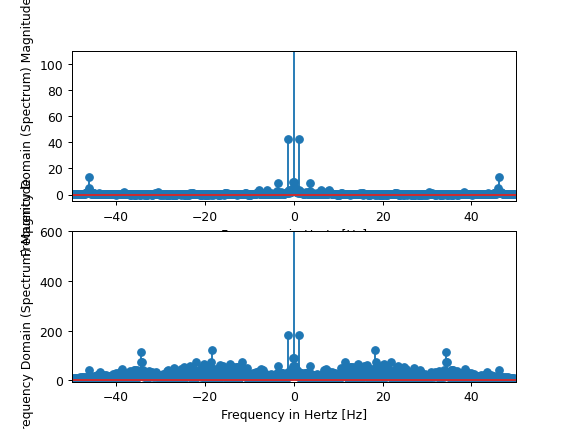

Strongest V wave
-3.62319 Hz  -  9.01  -  2.47669 rad
46.13527 Hz  -  13.14  -  1.85937 rad
-46.13527 Hz  -  13.14  -  -1.85937 rad
1.20773 Hz  -  42.16  -  -2.03739 rad
-1.20773 Hz  -  42.16  -  2.03739 rad
Strongest I wave
-34.29952 Hz  -  113.42  -  -2.49414 rad
18.35749 Hz  -  121.94  -  2.94654 rad
-18.35749 Hz  -  121.94  -  -2.94654 rad
1.20773 Hz  -  181.31  -  1.23656 rad
-1.20773 Hz  -  181.31  -  -1.23656 rad


In [8]:
import matplotlib.pyplot as plt

V = df_voltage.to_numpy()
X = fftpack.fft(V)
freqs = fftpack.fftfreq(len(df_voltage)) * fs

fig, (ax0, ax1) = plt.subplots(nrows=2)

ax0.stem(freqs, np.abs(X))

ax0.set_xlabel('Frequency in Hertz [Hz]')
ax0.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax0.set_xlim(-fs / 2, fs / 2)
ax0.set_ylim(-5, 110)

fig.show()

peaks, _ = signal.find_peaks(np.abs(X))
strongest_magnitudes = sorted(zip(freqs[peaks], np.abs(X)[peaks], np.angle(X)[peaks]), key=lambda x: x[1])
print('Strongest V wave')
for f, m, w in strongest_magnitudes[-5:]:
    print(f'{f:.05f} Hz  -  {m:.02f}  -  {w:.05f} rad')

I = df_current.to_numpy()
X = fftpack.fft(I)
freqs = fftpack.fftfreq(len(df_current)) * fs

ax1.stem(freqs, np.abs(X))

ax1.set_xlabel('Frequency in Hertz [Hz]')
ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax1.set_xlim(-fs / 2, fs / 2)
ax1.set_ylim(-5, 600)

fig.show()

peaks, _ = signal.find_peaks(np.abs(X))
strongest_magnitudes = sorted(zip(freqs[peaks], np.abs(X)[peaks], np.angle(X)[peaks]), key=lambda x: x[1])
print('Strongest I wave')
for f, m, w in strongest_magnitudes[-5:]:
    print(f'{f:.05f} Hz  -  {m:.02f}  -  {w:.05f} rad')

In [9]:
def calc_phase_shift(x0, x1, fs):
    X = fftpack.fft(x0)
    freqs = fftpack.fftfreq(len(x)) * fs
    peaks, _ = signal.find_peaks(np.abs(X))
    index_strongest_mag = np.argmax(np.abs(X)[peaks])
    phase0 = np.angle(X)[peaks][index_strongest_mag]

    X = fftpack.fft(x1)
    freqs = fftpack.fftfreq(len(x)) * fs
    peaks, _ = signal.find_peaks(np.abs(X))
    index_strongest_mag = np.argmax(np.abs(X)[peaks])
    phase1 = np.angle(X)[peaks][index_strongest_mag]
    
    return np.abs(phase0 - phase1)


for fr, df in dfs.items():
    print(fr, calc_phase_shift(df['busvoltage'].to_numpy(), df['raw_current'].to_numpy(), fs))
    
print('7.5 (no capacitor)', calc_phase_shift(df_no_cap['busvoltage'].to_numpy(), df_no_cap['raw_current'].to_numpy(), fs))

7.5 3.273956822380377
7.8 3.080153014595166
8.0 3.624601176960155
8.3 2.97565426767669
8.5 2.8849286218115977
8.7 3.3030219759593282
9.0 3.0649300953874947
9.3 3.213695524169861
9.5 3.180590673708374
9.8 2.984081439375366
7.5 (no capacitor) 1.804964736693758


<IPython.core.display.Javascript object>


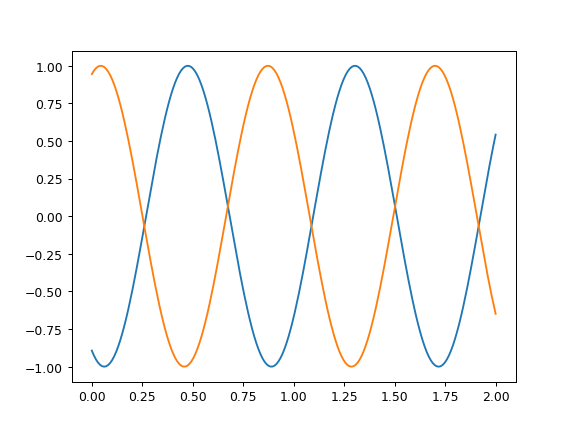

Phase shift is 3.27395 radians = 187.58 degrees


In [10]:
t = np.linspace(0, 2, int(2*fs))
V = np.sin(1.20773 * 2 * np.pi * t + -2.03739)
I = np.sin(1.20773 * 2 * np.pi * t + 1.23656)

fig, ax = plt.subplots()

ax.plot(t, V)
ax.plot(t, I)

fig.show()

print(f'Phase shift is {np.abs(2.03739 + 1.23656)} radians = {np.degrees(2.03739 + 1.23656):.02f} degrees')

<IPython.core.display.Javascript object>


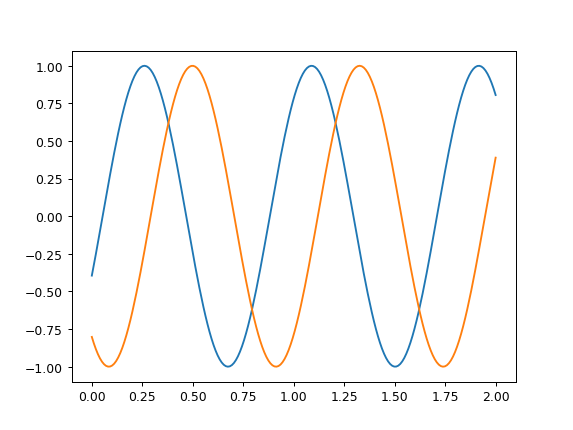

Phase shift is 3.27395 radians = 187.58 degrees


In [11]:
t = np.linspace(0, 2, int(2*fs))
V = np.sin(1.20773 * 2 * np.pi * t + -0.4056219567073067)
I = np.sin(1.20773 * 2 * np.pi * t + -2.2105866934010647)

fig, ax = plt.subplots()

ax.plot(t, V)
ax.plot(t, I)

fig.show()

print(f'Phase shift is {np.abs(2.03739 + 1.23656)} radians = {np.degrees(2.03739 + 1.23656):.02f} degrees')

In [12]:
fig = make_subplots()

x = np.arange(min(len(df) for df in dfs.values())) * 0.01

for flowrate, df in dfs.items():
    fig.add_trace(go.Scatter(x=x, y=df['busvoltage'] / 1000, name=f'Vbus ({flowrate} l/min)'))
    
fig.show()

In [13]:
fig = make_subplots()

for flowrate, df in dfs.items():
    fig.add_trace(go.Scatter(x=x, y=df['raw_current'] / 20, name=f'I ({flowrate} l/min)'))
    
fig.show()

In [14]:
from collections import defaultdict

features = defaultdict(list)

for fr, df in dfs.items():
    
    voltage = df['busvoltage'] / 1000
    current = df['raw_current'] / 20
    power = df['power']
    shuntvoltage = df['raw_shuntvoltage']
    
    features['flowrate'].append(fr)
    features['V_max'].append(voltage.max())
    features['V_min'].append(voltage.min())
    features['V_mean'].append(voltage.mean())
    features['V_midrange'].append(voltage.min() + (voltage.max() - voltage.min()) / 2)
    features['I_mean'].append(current.mean())
    features['P_mean'].append(power.mean())
    features['Vs_mean'].append(shuntvoltage.mean())
    
df_features = pd.DataFrame(data=features)
df_features.head()

,flowrate,V_max,V_min,V_mean,V_midrange,I_mean,P_mean,Vs_mean
0,7.5,7.596,7.248,7.436121,7.422,40.159662,298.301932,404.195652
1,7.8,7.860,7.348,7.608788,7.604,42.833825,323.059736,430.578743
2,8.0,8.184,7.816,8.006633,8.000,46.030424,368.939394,463.010909
3,8.3,8.444,8.060,8.243769,8.252,48.060964,395.789157,483.242169
4,8.5,8.648,8.320,8.485698,8.484,50.906167,432.400242,511.762999


In [15]:
import scipy

def curve(x, a, b):
    return a * x + b

popt, _ = scipy.optimize.curve_fit(curve, features['flowrate'], features['V_mean'])
print(f'{popt[0]:.30f} {popt[1]:.30f}')

fig = make_subplots()
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['V_mean'], name='Vmean'))
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['V_max'], name='Vmax'))
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['V_min'], name='Vmin'))

# flowrates_curve = np.linspace(7.5, 10, 1000)
# fig.add_trace(go.Scatter(x=flowrates_curve, y=curve(flowrates_curve, *popt), name='Curve'))

fig.show()

1.093291873776151446051585480745 -0.807589438289406880144838396518


In [16]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['P_mean'], name='P mean'))

popt, _ = scipy.optimize.curve_fit(curve, features['flowrate'], features['P_mean'])
print(f'{popt[0]:.30f} {popt[1]:.30f}')

fig.show()

148.450205494820409057865617796779 -826.204954144229304802138358354568


In [17]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['Vs_mean'], name='Vs mean'))

popt, _ = scipy.optimize.curve_fit(curve, features['flowrate'], features['Vs_mean'])
print(f'{popt[0]:.30f} {popt[1]:.30f}')

fig.show()

104.829305903196058125104173086584 -381.611312018416128921671770513058


In [18]:
def predict_flowrate_from_V(samples) -> float:
    return (samples['busvoltage'].mean() / 1000)
    
def predict_flowrate_from_V_curve(samples) -> float:
    a = 1.093291873776151446051585480745
    b = -0.807589438289406880144838396518
    return ((samples['busvoltage'].mean() / 1000) - b) / a

def predict_flowrate_from_P(samples) -> float:
    a = 148.450205494820409057865617796779 
    b = -826.204954144229304802138358354568
    return (samples['power'].mean() - b) / a


for window_size in (10, 20, 50, 100):
    print(f'window_size = {window_size} = {window_size / fs} s')

    for metric in (predict_flowrate_from_V, predict_flowrate_from_V_curve, predict_flowrate_from_P):
        total_error = 0
        total_samples = 0

        for fr, df in dfs.items():
            for window_start in range(0, len(df), window_size):
                if window_start + window_size >= len(df):
                    break

                samples = df.iloc[window_start:window_start + window_size]

                predicted_fr = metric(samples)

                total_error += (predicted_fr - fr)**2
                total_samples += 1

        print(f'MSE for {metric.__name__}: {total_error / total_samples}')

window_size = 10 = 0.1 s
MSE for predict_flowrate_from_V: 0.015524446189376411
MSE for predict_flowrate_from_V_curve: 0.008383372936223687
MSE for predict_flowrate_from_P: 0.0034284939316375418
window_size = 20 = 0.2 s
MSE for predict_flowrate_from_V: 0.014456991131639707
MSE for predict_flowrate_from_V_curve: 0.007490319678352851
MSE for predict_flowrate_from_P: 0.003174106895138164
window_size = 50 = 0.5 s
MSE for predict_flowrate_from_V: 0.010584691616568038
MSE for predict_flowrate_from_V_curve: 0.004373340688360388
MSE for predict_flowrate_from_P: 0.0028323733869517914
window_size = 100 = 1.0 s
MSE for predict_flowrate_from_V: 0.008840535561904724
MSE for predict_flowrate_from_V_curve: 0.002988869835896838
MSE for predict_flowrate_from_P: 0.002552921739128879


# Validation

In [19]:
dfs_cumulative = {}

for sample_file in Path('data').glob('capture_cumulative*'):
    filename = sample_file.stem.split('_')
    total_flow = float(filename[-2] + '.' + filename[-1])
    dfs_cumulative[total_flow] = pd.read_csv(sample_file, names=('busvoltage', 'raw_current', 'raw_shuntvoltage', 'power', 'estimated_flowrate', 'cumulative_flow'))

fig = make_subplots()

x = np.arange(max(len(df) for df in dfs.values())) * 0.01

for total_flow, df in dfs_cumulative.items():
    power_lpm = (df['power'] + 826.204954144229304802138358354568) / 148.450205494820409057865617796779
    calculated_flow = (power_lpm.mean() / 60 / 1000) * 0.01
    
    print(f'ground_truth={total_flow} (l) measured={df["cumulative_flow"].iloc[-1]} (l)')
    fig.add_trace(go.Scatter(x=x, y=df['power'], name=f'P ({total_flow} l)'))
    
    
fig.show()

ground_truth=8.3 (l) measured=8.41641 (l)
ground_truth=10.3 (l) measured=10.416638 (l)
ground_truth=14.4 (l) measured=14.388371 (l)
